<a href="https://colab.research.google.com/github/schmcklr/skill_extractor/blob/main/skill_extractor_analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 3:** Text Preprocessing and Skill Analysis

The present program offers a variety of features designed to track and analyze the progression of desired job qualifications over time. The program should be executed in Google Colab with GPU acceleration enabled. There are three implemented options for this:

1.   Frequency Analysis
2.   LDA Topic Modeling
3.   Dynamic LDA Topic Modeling


# 1. Load data, applying filters & defining basic functions
1.1 Import of preprocessed and translated job advertisements ([part 2](https://colab.research.google.com/drive/1EvylGHg4NLHiKnsAmW9l42AQUzLT2c5w#scrollTo=K2XUY2Qk6n7w&uniqifier=2))



In [1]:
!pip install --upgrade pandas --quiet
import pandas as pd

#Fetching preprocessed data
workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/job_data/job_data_preprocessed_extracted_qualifications.xlsx?raw=true'

# Import of tabs
job_data = pd.read_excel(workbook, sheet_name="Sheet1")

# Convert to lower case
job_data = job_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# Number of job advertisements before filtering
number_of_job_ads_before_filtering = str(len(job_data['description']))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 23.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.0 which is incompatible.


<ipython-input-1-40099f4ce539>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  job_data = job_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)


1.2 Define Filters for analysis

In [2]:
# Keywords for title filtering
job_keywords_title = ["bpm", "process", "bpmn", "business process management", "bpm", "bpmn", "business process analysis", "process improvement", "process analysis", "business process"]
# Keywords for description filtering
job_keywords_description = ["business process management", "bpm", "bpmn", "process improvement", "process analysis", "business process"]

# Filter #1: Filter job ads by keywords
# Option (1): Filter job titles
job_data = job_data[job_data['title'].str.contains('|'.join(job_keywords_title), case=False)]
filter_type = 'title'
# Option (2): Filter job description
#job_data = job_data[job_data['rawDescriptionTranslated'].str.contains('|'.join(job_keywords_description), case=False)]
#filter_type = 'description'


# Filter #2: Filter for specific years (deactivated by default)
filter_for_years = True
years = [2015, 2018, 2019, 2020 ,2021, 2022]

# Filter #3: Filter out internships/working student jobs (activated by default)
student_keywords = ["internship", "working student", "intern", "practical", "praktikum"]
#job_data = job_data[~job_data['title'].str.contains('|'.join(student_keywords), case=False)]

# Filter #4: Filter descripton by predefined skills (deactivated by default)
filter_by_skills = False

# User info (Number of job advertisements after filtering)
print('Filtering successfull! ' + str(len(job_data['description'])) + '/' + number_of_job_ads_before_filtering + ' Job advertisements are left.')

Filtering successfull! 307/2606 Job advertisements are left.


1.3 Preview of filtered job data




In [3]:
# Displaying job data
import pandas as pd
from IPython.display import display, HTML

# Set pandas display option
pd.set_option('display.max_colwidth', None)

job_data_display = job_data[['title', 'qualifications', 'created_at']].copy()  # create an explicit copy

# Convert 'created_at' column to datetime format to make sure it's in the correct date format
job_data_display['created_at'] = pd.to_datetime(job_data_display['created_at'])

# Extract the year from the 'created_at' column and store it in a new column 'year'
job_data_display['year'] = job_data_display['created_at'].dt.year
job_data_display = job_data_display[['title', 'qualifications', 'year']]

# Get 5 random rows from the DataFrame
job_data_display = job_data_display.sample(5)

# Set text alignment
#job_data_display = job_data_display.style.set_properties(**{'text-align': 'left'}).set_table_styles([
#   dict(selector='th', props=[('text-align', 'left')])
#])

# Display DataFrame with HTML
display(HTML(job_data_display.to_html().replace('\\n','<br>')))

,title,qualifications,year
2591,junior logistics manager - process improvement - job id: 2017351 | amazon.jobs,"first experience in distribution and/or fulfillment processes, ideally in fast-paced industrial, logistics or production environment you feel responsible for the quality of your work whilst striving for steady excellence and optimization data analysis skills and familiarity with supporting tools e.g. minitab, jmp, ms excel, ms access you have already gained your first professional experience in process management flexibility with work times and ready to assist in night shifts if required bachelor's or master's degree in operations, engineering or logistics high level of written, verbal and interpersonal communication skills bachelor's or master's degree with a tech or commercial focus expertise in lean management, six sigma and other oe tools analysis and problem-solving skills fluent in german and english",2022
1105,business analyst (m/w/d) im bereich business process & it transformation,"## you have very good analytical-conceptual skills, a high technical understanding and walkingwith work equipment such as ms office, data models, uml and sql at?bringing together very different partners are fun - a demanding job and a high burden does not frighten you ## do you want to conduct projects in the future or work as a product owner?it is good if you have several years of experience in project work (creating requirements analyzes, implementation requirements, testing and acceptance of it functions) ## creation ofbusiness analyzes including the specification of the requirements in the context of implementation concepts and user stories as the basis for it programming. ## your studies in mathematics, (economic) computer science, business administration or the insurance industry have a lotgood success completed ## you have knowledge and experience with regard to agile project work (scrum) and want to use them in a cross -functional team ## englishdo you master well in the word and writing settlement date: as quickly as possible",2020
852,business process analyst bestands-/lagermanagement (m/w/divers),"you have completed your graduate/master or equivalent conclusion in the areas of business administration, computer science, industrial engineering or mechanical engineering, logistics or can show an equivalent qualification you bring a good overall understanding of corporate management and experiencethe inventory management and warehousing (e.g.input/output/output/storage, inventory, picking) with you already have work and/or/orproject experience in the structuring, design and harmonization of global business processes in industrial companies can they are characterized by excellent analytical skills, communication skills at all management levels and businessunderstanding from good general knowledge of sap modules (e.g. mm, world cup) and overarchingintegration competence with focus on warehousing your knowledge of german and english in the word and writing (other languages are an advantage) are very good the development of strategies (long/medium-term) for redesigning business processes/models familiar with common processes of warehousing and their aids (e.g. use of bde) typical technical and commercial process architecture in industrial companies the coordination of business and it in large transformation programs project management-tools and frameworks",2019
197,intern: aftermarket systems and process developer (summer 2018),"applicants must be enrolled and pursuing a degree focusing on quality or process management, application development, business analysis or project management at an accredited school and have completed 30 semester hours prior to the start of the internship/co-op skills in process mapping, flow charts, value stream mapping, process development applicants must have a minimum cumulative grade point average of 3.0 business analysis and project management is a strong merit expert in microsoft office suite (mai

1.4 Initialise Lemmatizer

In [4]:
import nltk
import requests
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

# Initialise lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


1.5 Defining function for static LDA topic visualization
*   uses pyLDAvis to display gensim static LDA topic models

In [5]:
# Downgrade Versions to be compatible with pyldavis
#!pip install numpy==1.22
#!pip install pandas==2.0.0

# Needed for topic visualization
!pip install --upgrade pyldavis --quiet
#!pip install pyLDAvis==2.1.2 --quiet
#!pip install --upgrade numpy --quiet
#!pip install --upgrade pandas --quiet


import pyLDAvis
import pyLDAvis.gensim_models
import webbrowser

# Function which allows visualization of topic modeling
def visualization_with_vis(lda_model, corpus, dictionary, name):
  vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds='mmds')
  pyLDAvis.enable_notebook()
  pyLDAvis.display(vis)
  pyLDAvis.save_html(vis, name + '.html')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 56.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


# 2. Create skill list and skill extract function

Only be executed if filter_by_skills is active (deactivated by default):
*   Get skills from API (emsicloud)
*   Import of O*NET technology skills
*   Import od ESCO skills
*   Add list with custom skills
*   Define function for skill extraction

Always be executed:
*   Defining and Replacing skill synonyms









2.1 Connecting to Emsicloud (API)




In [6]:
if filter_by_skills:
  # Requesting access token
  url = "https://auth.emsicloud.com/connect/token"
  payload = "client_id=lwtnyxiuohd90aqc&client_secret=ZqV4d9LQ&grant_type=client_credentials&scope=emsi_open"
  headers = {'Content-Type': 'application/x-www-form-urlencoded'}
  response = requests.request("POST", url, data=payload, headers=headers)
  url = "https://emsiservices.com/skills/versions/latest/skills"

  # Storing access token
  access_token = response.json()["access_token"]

  # Requesting skill list
  querystring = {"fields": "name,type,category,subcategory", "limit": "100000"}
  headers = {'Authorization': 'Bearer ' + access_token}
  response = requests.request("GET", url, headers=headers, params=querystring)
  data = response.json()

  # Initialise skill array
  skills = []

  # Initialise skill dict
  skills_dict = {}

  # Add skills to skills_dict
  for entry in data["data"]:

      # Skill name
      if " (" in entry["name"]:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split("_(")[0])
      else:
          name = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
      # Skill category
      if entry['category'] is None:
          category = 'other'
      elif entry['category']["name"] == 'NULL':
          category = 'other'
      else:
          category = entry['category']["name"]
      # Skill Subcategory
      if entry['subcategory'] is None:
          subcategory = 'other'
      elif entry['subcategory']["name"] == 'NULL':
          subcategory = 'other'
      else:
          subcategory = entry['subcategory']["name"]
      # Add skill information to skills_dict
      skills_dict[name] = {
          'name': name,
          'category': category,
          'subcategory': subcategory
      }

  # Add skills to array
  for entry in data["data"]:
    if " (" in entry["name"]:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.','').split(" (")[0])
    else:
      skill = lemmatizer.lemmatize(entry["name"].lower().replace('.',''))
    skills.append(skill)

  # Store categories & subcategories
  categories = {}
  sub_categories = {}

  for skill in skills_dict.values():
      category = skill['category']
      if category not in categories:
          categories[category] = []
      categories[category].append(skill['name'])

  for skill in skills_dict.values():
      subcategory = skill['subcategory']
      if subcategory not in sub_categories:
          sub_categories[subcategory] = []
      sub_categories[subcategory].append(skill['name'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.2 Import of O*NET technology skills

In [7]:
if filter_by_skills:
  import pandas as pd

  # Import technology skills raw data
  skills_onet_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_onet.xlsx?raw=true'

  # Import of tabs
  skills_onet = pd.read_excel(skills_onet_workbook, sheet_name="Technology Skills")

  # Convert to list
  skills_onet = skills_onet['Example'].str.lower().tolist()

  # Append to skill list
  skills += skills_onet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.3 Import of ESCO skills

In [8]:
if filter_by_skills:
  !pip install odfpy --quiet
  import pandas as pd

  # Import ESCO skills raw data
  skills_esco_workbook = 'https://github.com/schmcklr/skill_extractor/blob/main/skill_data/skills_esco.ods?raw=true'

  # Import of tabs
  skills_esco = pd.read_excel(skills_esco_workbook, sheet_name="Skills")

  # Convert to list
  skills_esco = skills_esco['preferredLabel'].str.lower().tolist()

  # Append to skill list
  skills += skills_esco

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.4 Extend list with custom skills (can be adapted depending on the specific  example)

*   Creating own skill list
*   Replace blanks in compound skills with '_' to recognise them as one token
*   Definition of the skills defined in the Gartner Skillset
*   Convert to set remove duplicates and get faster access




In [9]:
if filter_by_skills:
  from re import U
  # Creating own skill list
  other_skills = ['python', 'c++', 'c', 'r', 'java', 'hadoop', 'scala', 'flask', 'pandas', 'spark', 'scikit-learn',
                  'numpy', 'php', 'sql', 'mysql', 'css', 'mongdb', 'nltk', 'fastai', 'keras', 'pytorch', 'tensorflow',
                  'ruby', 'javascript', 'django', 'react', 'reactjs', 'ai', 'ui', 'tableau', 'crm', 'modeling',
                  'bpm', 'vision', 'communication', 'analysis', 'design', 'excel', 'itil', 'data',
                  'governance', 'police', 'simulation', 'automation', 'kpi', 'erp', 'statistic', 'sap', 'german',
                  'english', 'kafka', 'api', 'rest', 'database', 'metrics', 'autonomy']

  # Creating composed skills (needed for lemmatization that words considered as one word)
  composite_skills = ['process_modeling', 'application_development', 'change_techniques', 'business_case',
                      'business_process_improvement', 'business_process', 'team_player', 'web_development',
                      'quality_management']

  # Custom list for BPM Gartner skill set
  gartner_skill_set = ['business_case', 'business_process', 'project_management', 'organizational', 'communication',
                      'change_management', 'process_discovery', 'process_mod', 'extract_data', 'data_visualization',
                      'architecture', 'bpmn', 'bpm', 'agile_development', 'optimization', 'user_experience', 'ui','process_management'
                      ]

  # Extending skill list fetched from Emsi and O*NET
  skills += other_skills
  skills += composite_skills
  skills += gartner_skill_set

  # Replace the blanks with '_' to recognise compound skills
  for i in range(len(skills)):
    skills[i] = skills[i].replace(" ", "_")

  # Convert to set remove duplicates and get faster access
  skills = set(skills)

  # Number of unique skill terms
  print('Number of unique skills: ' + str(len(skills)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.5 Create list with skill synonyms


In [10]:
skill_synonyms = {
    'artificial_intelligence' : ['ai', 'artifical_intelligence'],
    'user_interface': ['ui'],
    'business_process_management': ['bpmn', 'bpm'],
    'english_language': ['english', 'fluent_english'],
    'german_language': ['german'],
    'microsoft_excel': ['excel', 'especially_excel'],
    'crm': ['customer_relationship_management'],
    'business_intelligence': ['bi'],
    'sap_fi': ['fi'],
    'sap_hana': ['hana'],
    'powerpoint': ['power_point'],
    'bachelor_degree': ['bachelor'],
    'master_degree': ['master'],
    'communication_skill': ['communication', 'strong_communication', 'communicate', 'communication_strength', 'communicative'],
    'analytical_skill': ['analytical'],
    'automation': ['automation_anywhere'],
    'team_player': ['team']
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.6 Define function for skill extraction and replacing skill synonyms

In [11]:
# Function for skill extraction
def extract_skills(df_column):
  df_column = df_column.apply(lambda x: " ".join(x for x in x.split() if x in skills))
  return df_column

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Function for replacing synonym skills
def replace_synonym_skills(filtered_docs, skill_synonyms):
    for doc in filtered_docs:
        for i in range(len(doc)):
            for key in skill_synonyms.keys():
                if doc[i] in skill_synonyms[key]:
                    doc[i] = key
                    break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Text preprocessing


*  Define stopwords and stopwords removal function  
*  Define function for special character removing
*  Split job dataframe by year
*  Text Preprossesing
*  Compute bigrams, trigrams with gensim phraser
*  Define and revert phrases to be ignored


3.1 Define stopwords and stopwords removal function   





*   3.1.1 Defining stopword list


In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# English stopwords
english_stopwords = stopwords.words('english')

# German stopwords
german_stopwords = stopwords.words('german')

# Custom stopwords list
custom_stop_words = ['genetics','go', 'public', 'transport', 'pregnancy','cash', 'le', 'register', 'make', 'm', 'nice', 'work', 'b',
                    'client', 'skill', 'good', 'allianz', 'celonis', 'internship', 'opportunity', 'robotics', 'billing', 'talent'
                    'chemistry', 'disability',  'working', 'offer', 'product', 'requirement', 'und', 'toyota', '1st', 'paris',
                    'investment', 'consulting', 'banking', 'merchandising', 'stock', 'amazon', 'are', 'amadeus', 'oe', 'must', 'celonis', 'are',
                    'automotive', 'safe', 'best', 'privacy', 'well', 'work', 'strong', 'commercial', 'dealer', 'you', 'none', 'entry', 'level',
                    'br', 'kpmg', 'complex', 'ability', 'experience', 'business', 'first', 'high', 'relevant', 'system', 'excellent',
                    'use', 'personal', 'knowledge', 'understanding', 'plus', '#', 'br_br', 'e_g', 'ideally', 'amazon_equal'
                    'able', 'year', 'school', 'scor', 'required', 'new', 'position', 'bull', 'br', 'already', 'gained', 'looking',
                    'already_gained', 'would', 'win', 'field', 'br_bull', 'e', 'de', 'etc', '#_#', 'within', 'company', 'background', 'ee',
                    'great', 'et', 'month', 'candidate', 'enviroment', 'uf0b7', 'fluent', 'need', 'process', 'management', 'ä', 'process',
                    'n', 'free', 'part', 'point', 'car', 'like', 'would_plus', 'understand', 'want', 'last', 'g', 'alytics', '+2',
                    'month_full', 'using', 'f', 'availability', 'http_www', 'closely', 'mercedes-benz', 'sixt', 'need_choose', '++',
                    'area', 'customer', 'industry', 'able', 'equivalent', 'including', 'related', 'stakeholder', 'proven', 'preferably',
                    'oriented', 'change', 'time', 'interest', 'preferred', 'similar', 'role', 'basic', 'focus', 'expertise', 'advantage',
                    'drive', 'know', 'hand', 'multiple', 'gap_year', 'way_working', 'full', 'medium', 'office', 'tool', 'structured',
                    'comparable', 'least', 'pronounced', 'bring', 'year_professional', 'chemistry', 'lufthansa', '+49', 'yes','degree','end',
                    'solution', 'previous', 'drive_celonis', 'celonis','unicredit', 'bank',


                    ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*   3.1.2 Defining functions for stopword removal


In [14]:
import re

# Function for removing stopwords from dataframe
def remove_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in english_stopwords and token not in german_stopwords]
  return filtered_doc

# Function for removing custom stopwords from dataframe
def remove_custom_stopwords(doc):
  filtered_doc = []
  filtered_doc = [token for token in doc if token not in custom_stop_words]
  return filtered_doc

# Function for removing tokens that only contain numbers
def remove_numeric_tokens(tokens):
    return [token for token in tokens if not bool(re.match(r'^[0-9]+$', token))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.2 Defining function for special character removing

In [15]:
import re

# List of exceptions (combinations that should not be removed)
exceptions = ['c++', 'c#']

# Function to remove special characters while considering exceptions for individual tokens
def remove_special_characters(tokens):
    # Create a regular expression to remove special characters
    special_characters_pattern = r'[^\w\s]'

    # Create a regular expression for exceptions
    exceptions_pattern = '|'.join(re.escape(exception) for exception in exceptions)

    # Initialize a list to store the cleaned tokens
    cleaned_tokens = []

    for token in tokens:
        # Combine the two regular expressions and remove special characters,
        # but keep the exceptions unchanged
        cleaned_token = re.sub(f'({exceptions_pattern})|(?:{special_characters_pattern})', r'\1', token)
        cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.2 Split job dataframe by year

In [16]:
# Group the DataFrame by year
grouped = job_data.groupby(job_data['created_at'].dt.year)

# Create a dictionary to store the new DataFrames
year_dfs = {}

# Split groups into separate dataframes and store them in a dictionary
for year, group in grouped:
    year_dfs[year] = group.copy()

# Filter by years
if filter_for_years:
  year_dfs = {year: df for year, df in year_dfs.items() if year in years}

# Number of jobs ads per year
number_of_ads_per_year = {}
for year in year_dfs:
  number_of_ads_per_year[year] = len(year_dfs[year]['qualifications'])

# User Info (Number of job ads per year)
print(number_of_ads_per_year)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{2015: 8, 2018: 20, 2019: 96, 2020: 55, 2021: 95, 2022: 27}


3.3 Visualisation of job postings by year

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x500 with 0 Axes>

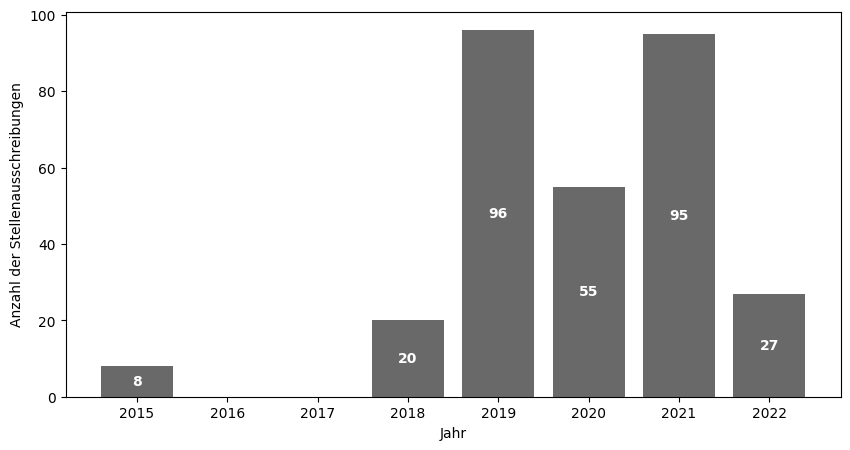

In [17]:
import matplotlib.pyplot as plt

# Set color
color = '#696969'

# Sort the data by years
sorted_data = sorted(number_of_ads_per_year.items())

# Creating a figure object
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(10,5))

# Creating bar plot with job data
years = [x[0] for x in sorted_data]
counts = [x[1] for x in sorted_data]
bars = ax.bar(years, counts, color=color)

# Set lable for number of postings
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height/2, int(height),
            ha='center', va='center', color='white', fontweight='bold', fontsize=10)

# Set axis, labels and title
ax.set_xlabel('Jahr', fontsize=10)
ax.set_ylabel('Anzahl der Stellenausschreibungen', fontsize=10)
#plt.title("Number of job postings by year", fontsize=16)

# Calculate the average
mean = sum(counts) / len(counts)
#line = plt.axhline(y=mean, xmin=0, xmax=1, ls='--', color=color)
mean_text = 'Im Durchschnitt 'f"{mean:.0f} Stellenanzeigen"
#plt.text (2015, mean+20, mean_text,fontsize=12,color=color, rotation='horizontal')
# Display chart
plt.show()

3.4 Text Preprossesing
*   Tokenize documents
*   Remove numbers, but not words that contain numbers
*   Remove stopwords
*   Lemmatization


In [18]:
!pip install spacy --quiet
nltk.download('omw-1.4');
nltk.download('wordnet');
nltk.download('punkt');
import spacy
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

# Create list whith all documents for tasks like computing bigrams/trigrams
docs_all = []
filtered_docs_all = []
docs_by_year = {}
docs_by_year_corpus = {}
new_doc_complete_all = []
filtered_docs_all_corpus = []

# Preprossesing based on year
for year in year_dfs:

  docs = list(year_dfs[year]['qualifications'])

  # Tokenize the documents
  tokenizer = RegexpTokenizer(r'[\w#+]+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words

  # Remove numbers, but not words that contain numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

  # Remove words that are only one character
  docs = [[token for token in doc if len(token) > 1 or token in ['r', 'c']] for doc in docs]

  # Innizialise lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Lemmatize the documents
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

  # Remove stopwords
  docs = [remove_stopwords(doc) for doc in docs]

  # Remove special characters
  docs = [remove_special_characters(doc) for doc in docs]

  # Add processed docs to docs_by_year dict
  docs_by_year[year] = docs

  # Add processed docs to docs_all list (used for overall lda model and bigram/trigram calculation)
  docs_all += docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


3.5 Compute bigrams, trigrams with gensim phraser

In [19]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser

# Compute bigrams
bigram = Phrases(docs_all, min_count=7)#, threshold=6)
# Compute trigrams
trigram = Phrases(docs_all, min_count=7)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

3.6 Define phrases to be ignored and function to revert unwanted phrases

In [20]:
# Define word pairs to be ignored within the phrases creation
ignored_phrases = ['german_english', 'example_sentence', 'bachelor_master', 'verbal_written', 'written_spoken', 'english_german', 'spoken_written',
'written_verbal', 'oral_written', 'word_excel', 'fluency_english', 'dutch_french', 'python_r', 'excel_powerpoint', 'economics_mathematics',
'end_end', 'french_dutch', 'advanced_excel', 'lean_six', 'excel_word', 'powerpoint_excel', 'javascript_html', 'mathematics_comparable',
'mathematics_statitic', 'html5_cs']

# Revert unwanted phrases back into individual words in the document
def revert_unwanted_phrases(doc, ignored_phrases):
  for phrase in doc:
    if '_' in phrase and phrase in ignored_phrases:
        word1, word2 = phrase.split('_')
        index = doc.index(phrase)  # Index of the original trigram
        doc.remove(phrase)  # Remove the original trigram
        doc.insert(index, word1)  # Insert the first word at the original position
        doc.insert(index + 1, word2)  # Insert the second word right after
  return doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3.7 Preprocessing tokens

There are three options for token filterung:
*   Option #1: Keep only tokens that are included in the skills list
*   Option #2: Use all words, except stopwords (default)
*   Option #3: POS-Filter (Keep only Nouns, Verbs & Adjectives)
*   Creating bigrams/trigrams
*   replace synonym skills



In [21]:
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

# Preprossesing based on year
for year in docs_by_year:

  # Load docs for year
  docs = docs_by_year[year]

  # Creating bigrams/trigrams, filter out phrases that should be ignored
  for idx in range(len(docs)):
      # Creating bigrams/trigrams calculated by gensim phraser
      docs[idx] = trigram[bigram[docs[idx]]]
      # Filter out phrases that should be ignored
      docs[idx] = revert_unwanted_phrases(docs[idx], ignored_phrases)

  # Store filtered docs
  filtered_docs = []
  # Filter docs (Only necessary if using the 'skills' list)
  for doc in docs:
      # Define tokens
      tokens = doc

      # OPTION #1: Keep only tokens that are included in the skills list
      if filter_by_skills:
        new_tokens = [token for token in tokens if token in skills]

      # OPTION #2: Use all words, custom except stopwords (default)
      if not filter_by_skills:
        new_tokens = [token for token in tokens]

      # OPTION #3 POS-Tragging (Exclude Verbs)
      # POS-Tagging
      tagged_tokens = pos_tag(new_tokens)
      # Filter and keep all words except verbs
      new_tokens = [token for token, tag in tagged_tokens if not tag.startswith('VB')]

      # Convert list of tokens into a string and add it to the new list of documents
      filtered_docs.append(new_tokens)

  # Replace synonym skills
  replace_synonym_skills(filtered_docs, skill_synonyms)

  # Remove Custom Stopwords
  filtered_docs = [remove_custom_stopwords(doc) for doc in filtered_docs]

  # Store filtered docs by year
  docs_by_year[year] = filtered_docs

  # Store filtered docs for the entire period
  filtered_docs_all += filtered_docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


3.8 Visualise number of tokens per document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1000x500 with 0 Axes>

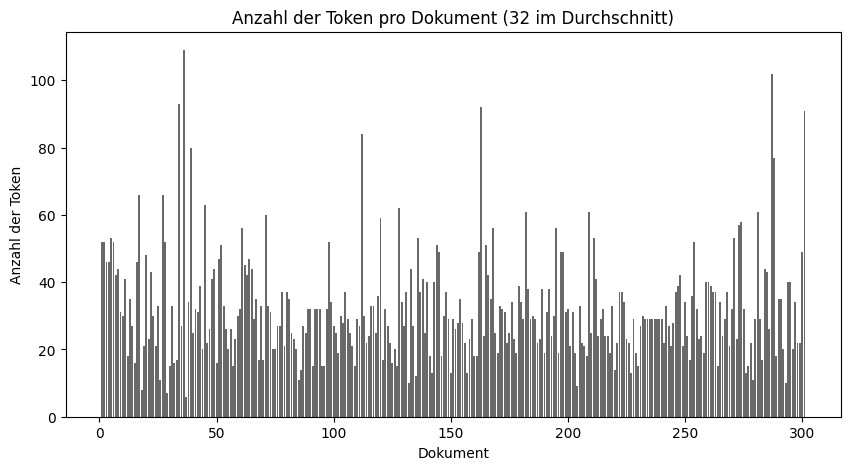

In [22]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(10, 5))

# Create subplots within the figure with a specific size
fig, ax = plt.subplots(figsize=(10, 5))

# Determine the number of tokens per document
token_counts = [len(doc) for doc in filtered_docs_all]

# Create an index for the x-axis
x = range(1, len(filtered_docs_all) + 1)

# Calculate the token mean
mean = sum(token_counts) / len(token_counts)

# Create the chart and define labels
plt.bar(x, token_counts,color=color)
plt.xlabel('Dokument')
plt.ylabel('Anzahl der Token')
plt.title('Anzahl der Token pro Dokument (' + f"{mean:.0f} im Durchschnitt)")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


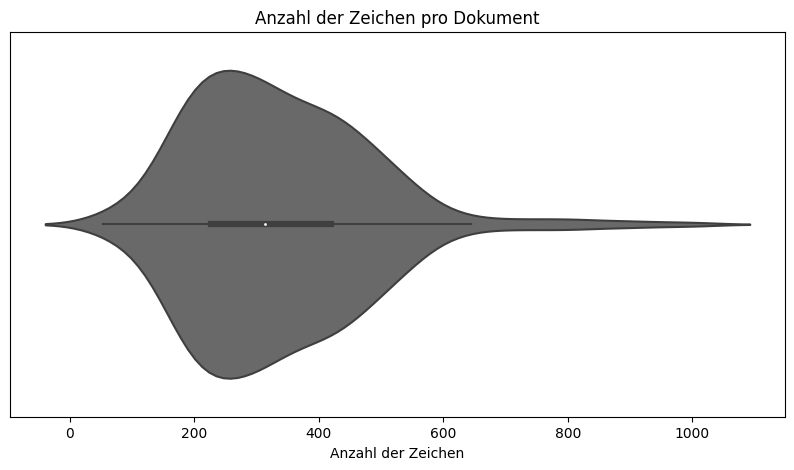

Min: 54
Max: 999
Median: 314
Durchschnitt: 335


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Zeichenanzahl pro Dokument (ohne Unterstrich "_")
char_counts = [len(" ".join(doc).replace("_", "")) for doc in filtered_docs_all]

# Erstellen Sie den horizontalen Violinplot
plt.figure(figsize=(10, 5))
sns.violinplot(x=char_counts, color=color, orient="h")

#plt.ylabel('Dokument')
plt.yticks([])
plt.xlabel('Anzahl der Zeichen')
plt.title('Anzahl der Zeichen pro Dokument')

plt.show()

# Berechnen Sie Min, Max, Median und Durchschnitt
min_value = min(char_counts)
max_value = max(char_counts)
median_value = statistics.median(char_counts)
mean_value = statistics.mean(char_counts)

# Ausgabe der Werte als Text unter dem Plot
print(f'Min: {min_value}')
print(f'Max: {max_value}')
print(f'Median: {median_value}')
print(f'Durchschnitt: {mean_value:.0f}')

3.9 Wordcloud representation for each year

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
from ipywidgets import interact, widgets

# Define colors
color_list = [
    "#336699", "#993366", "#cc6600", "#cc3366",
    "#99cc33", "#cc9999", "#3399cc", "#ff9900",
    "#669933", "#ff6633", "#66cccc", "#cc6600",
    "#993300", "#33cccc", "#ff3366", "#66cc66",
    "#ff3333", "#3366cc"
]

color_index = 0

# Generate next color
def generate_next_color():
    global color_index
    if color_index >= len(color_list):
        raise ValueError("All colors have been used.")

    next_color = color_list[color_index]
    color_index += 1
    return next_color

# Generate color mapping for each year
colors = {year: generate_next_color() for year in docs_by_year.keys()}

# Generate wordcloud
def generate_wordcloud(year):
    docs_list = docs_by_year[year]
    docs = [word for sublist in docs_list for word in sublist]
    text = ' '.join(docs)

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          min_font_size=5,
                          colormap='viridis',  # You can choose a different colormap here
                          color_func=lambda *args, **kwargs: colors[year]).generate(text)  # Color customization

    # Display the wordcloud
    plt.figure(figsize=(10, 4), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    #plt.title(f"Wordcloud for Year {year}", color=colors[year], fontsize=20)
    plt.show()

# Interactive slider function
interact(generate_wordcloud, year=widgets.Dropdown(options=docs_by_year.keys()));

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(Dropdown(description='year', options=(2015, 2018, 2019, 2020, 2021, 2022), value=2015), …

TESTT

In [25]:
!pip install tomotopy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.5 MB/s eta 0:00:00


In [26]:
import tomotopy as tp

# Wandele die Liste von Listen in eine Liste von Strings um
list_of_strings = [' '.join(doc) for doc in filtered_docs_all]

corpus = tp.utils.Corpus(tokenizer=tp.utils.SimpleTokenizer(), stopwords=['.'])
# data_feeder yields a tuple of (raw string, user data) or a str (raw string)
corpus.process(list_of_strings)

# make LDA model and train
mdl = tp.SLDAModel(k=12, min_cf=0, min_df=5, corpus=corpus)
mdl.train(0)
print('Num docs:', len(mdl.docs), ', Vocab size:', len(mdl.used_vocabs), ', Num words:', mdl.num_words)
print('Removed top words:', mdl.removed_top_words)
for i in range(0, 1000, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(mdl)

# ranking the candidates of labels for a specific topic
labeler = tp.label.FoRelevance(mdl, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(mdl.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in mdl.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

Num docs: 301 , Vocab size: 502 , Num words: 7390
Removed top words: []


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Iteration: 0	Log-likelihood: -6.565246778315233
Iteration: 10	Log-likelihood: -6.331363914396831
Iteration: 20	Log-likelihood: -6.26251070778086
Iteration: 30	Log-likelihood: -6.207690638440871
Iteration: 40	Log-likelihood: -6.1696552478855775
Iteration: 50	Log-likelihood: -6.146844609160385
Iteration: 60	Log-likelihood: -6.10317472185995
Iteration: 70	Log-likelihood: -6.089839396259782
Iteration: 80	Log-likelihood: -6.0578323868235655
Iteration: 90	Log-likelihood: -6.025797885180488
Iteration: 100	Log-likelihood: -6.027721853314298
Iteration: 110	Log-likelihood: -6.034230110198461
Iteration: 120	Log-likelihood: -6.026873087891061
Iteration: 130	Log-likelihood: -6.009057563954665
Iteration: 140	Log-likelihood: -6.014838819171482
Iteration: 150	Log-likelihood: -6.019678949648376
Iteration: 160	Log-likelihood: -6.005710171249787
Iteration: 170	Log-likelihood: -6.0063897797800045
Iteration: 180	Log-likelihood: -5.987720831861677
Iteration: 190	Log-likelihood: -6.003425262527633
Iteration:

# 4. Static Topic Modeling (LDA model)


*   Setting model parameter
*   Train static LDA model (all data)
*   Calculate probability of topics per year
*   Extract token frequencies (all data)
*   Train LDA model (by year)
*   Extract token frequencies (by year)
*   Export topic visualisation (all data, by year)

4.1 Setting model parameter

In [27]:
import numpy as np
# Set training parameters
num_topics = 15 # Specifies the number of topics to be extracted from the corpus
chunksize = 5000 # Sets the number of documents used in each chunk during training to avoid memory issues
passes = 20 # Sets the number of training passes to improve the model accuracy
iterations = 400 # Sets the maximum number of iterations during the inference process for each document, which determines the accuracy of the model

# Number of keywords per topic to display
num_keywords = 20

# Setting the seed to ensure the reproducibility of the results
seed = 22
np.random.seed(seed)

# Calculation of coherence for evaluation (disabled by default)
calculate_coherence = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4.2 Train static LDA model (all data)


*   used gensim for lda topic modeling, bag of words and tfidf can be selected


In [28]:
!pip install gensim --quiet
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# Create dictionary representation of the documents
dictionary = Dictionary(filtered_docs_all)

# Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
#dictionary.filter_extremes(no_below=10, no_above=0.8)

# Option #1: Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in filtered_docs_all]

# Option #2: TF-IDF representation of the documents (deactivated by default)
#tfidf = TfidfModel(corpus)
#corpus = tfidf[corpus]

# Make an index to word dictionary
temp = dictionary[0]  # Used only to "load" the dictionary
id2word = dictionary.id2token

# Lda model
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    random_state=seed
)

# Calculation of Coherence
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=model, texts=filtered_docs_all,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence (c_v):', coherence_lda)

# Calculation of Perplexity
perplexity_lda = model.log_perplexity(corpus)
print('Perplexity:', perplexity_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence (c_v): 0.47539216394801476
Perplexity: -6.906726896608831


4.3 Display topics and topic keywords

In [29]:
import pandas as pd
from IPython.display import display, HTML

# Extract the top keywords for each topic
topics = model.show_topics(num_topics=num_topics, num_words=num_keywords, formatted=False)

# Create a table with the topics and keywords
table_data = []
for topic_id, topic_words in topics:
    keywords = [word for word, _ in topic_words]
    table_data.append([f"Topic {topic_id}", ", ".join(keywords)])

# Sort the table by topic index
table_data.sort(key=lambda x: int(x[0].split()[1]))

# Create the dataframex
df = pd.DataFrame(table_data, columns=["Topic", "Keywords"])

# Set the width of the "Keywords" column
pd.set_option("display.max_colwidth", 250)

# Display table
display(df)

# Print topics with probabilities
#for idx, topic in model.print_topics(-1):
    #print(f'Topic: {idx} \nWords: {topic}\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Keywords
0,Topic 0,"english_language, communication_skill, mathematics, business_administration, study, german_language, business_informatics, application, technology_forward, computer_science, want_actively, economics, similar_area, analytical_skill, strong_interes..."
1,Topic 1,"computer_science, automation, english_language, study, python, german_language, practical_experience, java, comparable_field, completed_study, net, implementation, requirement_analysis, automation_desktop, c_c, automation_cognitive, script_ruby, ..."
2,Topic 2,"english_language, team_player, communication_skill, technology, data, environment, project, business_administration, organization, german_language, methodology, spirit, bachelor_degree, master_degree, sql, language, agile, highly, structure, micr..."
3,Topic 3,"english_language, project_management, german_language, industrial_company, project, master_degree, development, technical, communication_skill, business_administration, framework, architecture, general, global, computer_science, large, competence..."
4,Topic 4,"english_language, team_player, analytical_skill, computer_science, engineering, communication_skill, application, business_process_management, french, german_language, technical, project, economics, service, analysis, dutch, master_degree, softwa..."
5,Topic 5,"project, database, team_player, initial, sql, programming_language, technology, server, automation, english_language, assume, websphere, method, challenge, core, communication_skill, data, economics, microsoft, university"
6,Topic 6,"team_player, english_language, german_language, engineering, plant, communication_skill, responsible, qualification, goal, technology, enjoy, professional_experience, creative, affinity, lean, production, optimization, forward, actively, environment"
7,Topic 7,"microsoft_excel, communication_skill, project, study, independent, english_language, powerpoint, analytical_skill, task, international, supply_chain, word, environment, method, logistics, methodology, collaboration, team_player, program, teamwork"
8,Topic 8,"bachelor_degree, english_language, environment, fluent_german, first_professional, expertise_lean, interpersonal, data_analysis, flexibility_work, striving_steady, time_ready, analysis_problem, logistics_production, tool_minitab, jmp_excel, ideal..."
9,Topic 9,"english_language, data, project, team_player, german_language, communication_skill, operational_excellence, method, one, automation, analytical_skill, 5, motivation, comprehensive, large, financial, technology, professional_experience, operation,..."


4.4 Export topic visualisation with pyldavis (all data)

In [30]:
# Visualization of topics
visualization_with_vis(model, corpus, dictionary,'overall')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


4.5 Calculate token frequencies (token counted only once per doc, all data)

In [31]:
# Extract the frequency of each token from the corpus
token_frequencies = {}
for doc in corpus:
    tokens_in_doc = set()
    for token_id, freq in doc:
        token = dictionary[token_id]
        if token not in tokens_in_doc:
            tokens_in_doc.add(token)
            if token in token_frequencies:
                token_frequencies[token] += 1
            else:
                token_frequencies[token] = 1

# Sort the tokens by descending frequency
sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4.6 Store lda models & token frequencies

In [32]:
# Store lda model, token frequencies for each year
lda_models = {}
token_freqs = {}
lda_model_overall = []
token_freqs_overall = []
token_freqs_overall_dict = {}

# Add model to lda_model list
lda_model_overall = model
token_freqs_overall = sorted_tokens
token_freqs_overall_dict = {tup[0]: tup[1] for tup in sorted_tokens}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4.7 Calculate the probabilities of topics over years and visualize them



*   Calculate probabilities




In [33]:
# List of years
years = docs_by_year.keys()

# Save topic distribution for each year
topic_distributions = {}

# Extract topic distribution for each year
for year in years:
    documents = docs_by_year[year]  # List of documents for the current year

    # Convert documents to BoW format for the LDA model
    year_corpus = [dictionary.doc2bow(document) for document in documents]

    # Extract topic distribution for each document of the current year
    topic_distribution_year = []
    for document in year_corpus:
        topic_probs = np.zeros(model.num_topics)
        topic_distribution = model.get_document_topics(document)
        for topic, prob in topic_distribution:
            topic_probs[topic] = prob
        topic_distribution_year.append(topic_probs)

    topic_distributions[year] = topic_distribution_year

# Create an array to store influence scores for each year and topic
influence_scores = np.zeros((len(years), model.num_topics))
for i, year in enumerate(years):
    for topic in range(model.num_topics):
        topic_probs = np.array(topic_distributions[year])[:, topic]
        influence_scores[i, topic] = np.mean(topic_probs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*   Visualize the topic probabilities over the years
  *   Each subplot represents a topic and contains a line plot showing the probability scores of the topic over the years



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


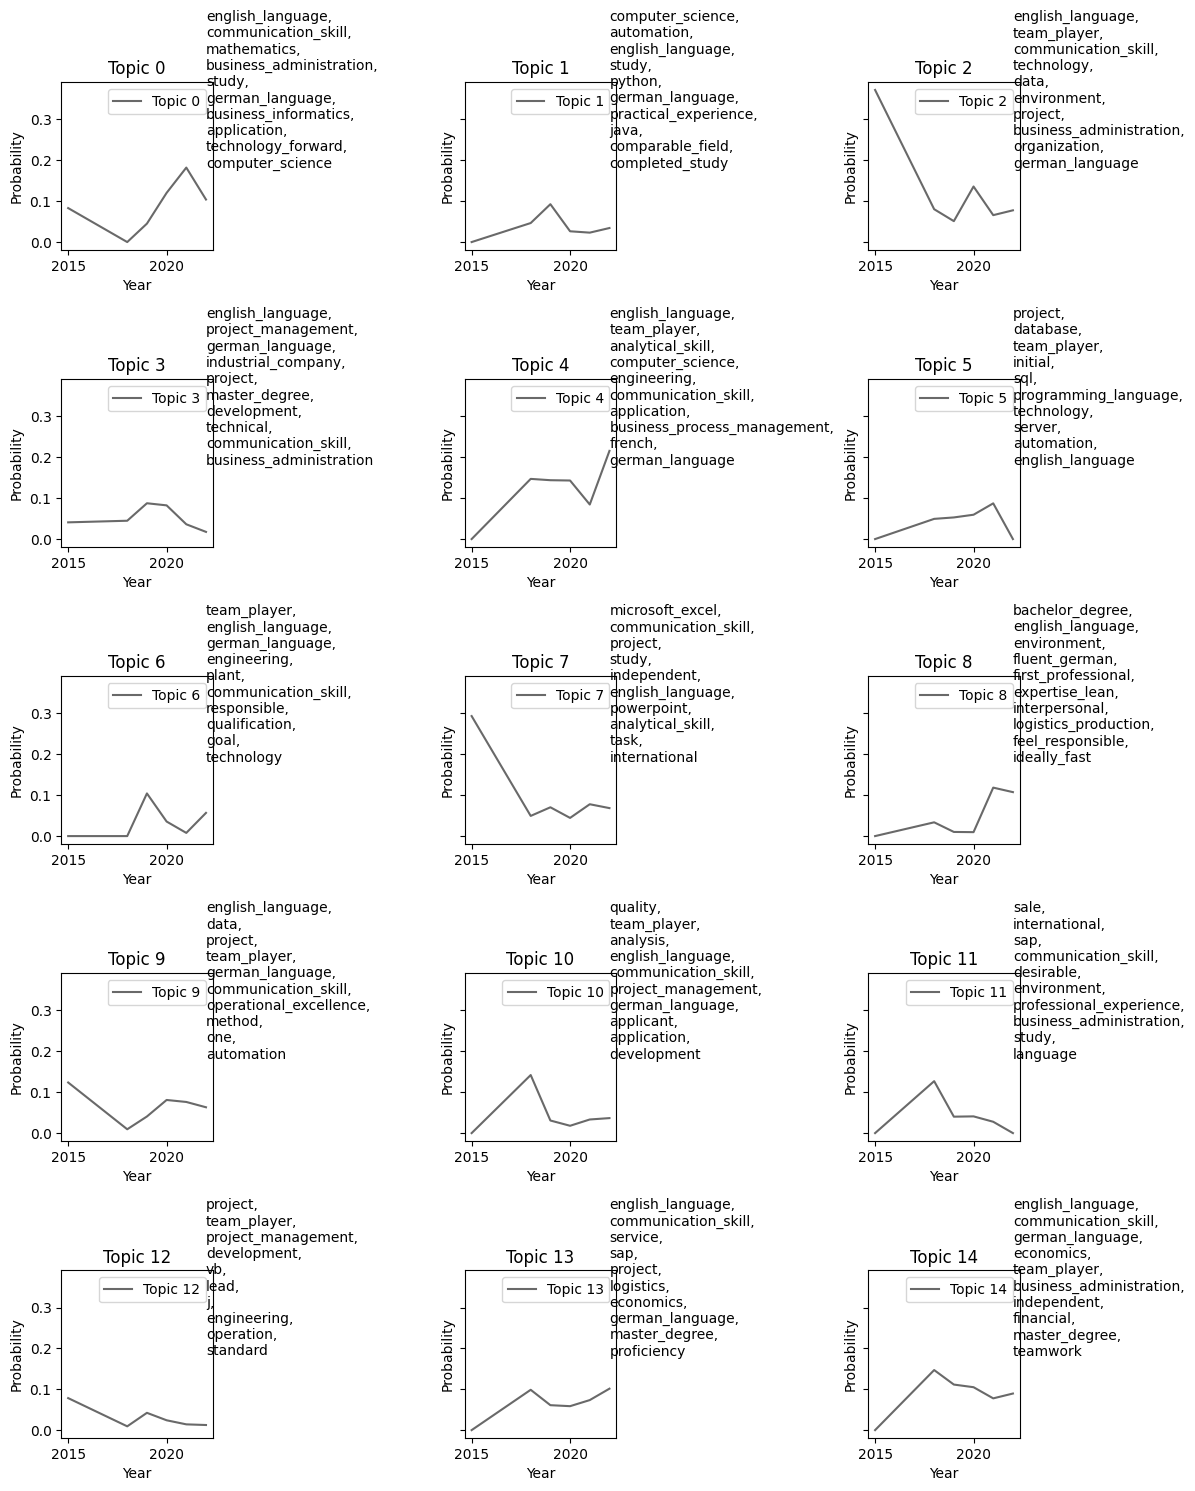

In [34]:
# Determine the number of rows and columns for the subplots
num_rows = int(np.ceil(model.num_topics / 3))  # Number of rows
num_cols = min(3, model.num_topics)  # Number of columns (maximum 3)

# Set the size of the overall plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows), sharey=True)

# Plot bar charts for each topic
for topic in range(model.num_topics):
    ax = axes[topic // num_cols, topic % num_cols]  # Select current axis

    # Plot lines for each year
    ax.plot(years, influence_scores[:, topic], label=f"Topic {topic}", color=color)


    # Extract the top 10 words of the topic
    top_word_ids = [word_id for word_id, _ in model.get_topic_terms(topic, topn=10)]
    top_words = [dictionary[word_id] for word_id in top_word_ids]
    top_words_str = ', '.join(top_words)

    ax.set_xlabel("Year")
    ax.set_ylabel("Probability")
    ax.set_title(f"Topic {topic}")
    ax.legend()

    # Add the top 10 words of the topic as text (only once for the topic)
    ax.text(list(years)[-1], np.max(influence_scores), '\n'.join(top_words_str.split()), ha='left', va='center')

# Remove extra axes if the number of topics is not divisible by 3
if model.num_topics % 3 != 0:
    for i in range(model.num_topics, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

4.8 Train static LDA model & export token frequencies (by year)

In [35]:
import warnings
from gensim.models import LdaModel
from gensim.models.phrases import Phrases

# Ignore warning caused by gensim library, improve readability
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Analysis based on year
for year in docs_by_year:

  # User info
  print('Analysing job advertisement data of ' + str(year) + ' (' + str(len(docs_by_year[year])) + ')...')

  docs = docs_by_year[year]

  # Create a dictionary representation of the documents
  dictionary = Dictionary(filtered_docs_all)

  # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
  #dictionary.filter_extremes(no_below=10, no_above=0.8)

  # Bag-of-words representation of the documents
  corpus = [dictionary.doc2bow(doc) for doc in docs]


  # Make an index to word dictionary.
  temp = dictionary[0]  # Used only to "load" the dictionary
  id2word = dictionary.id2token

  # Train lda model
  lda_model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes
  )

  # Print topics
  for idx, topic in model.print_topics(-1):
      print(f'Topic: {idx} \nWords: {topic}\n')


  # Extract the frequency of each token from the corpus (only counted once per doc)
  token_frequencies = {}
  for doc in corpus:
      tokens_in_doc = []
      tokens_in_doc = set()
      for token_id, freq in doc:
          token = dictionary[token_id]
          if token not in tokens_in_doc:
              tokens_in_doc.add(token)
              if token in token_frequencies:
                  token_frequencies[token] += 1
              else:
                  token_frequencies[token] = 1


  # Sort the tokens by descending frequency
  sorted_tokens = []
  sorted_tokens = sorted(token_frequencies.items(), key=lambda x: x[1], reverse=True)

  # Add model to lda_model list
  lda_models[year] = lda_model
  token_freqs[year] = sorted_tokens

  # Topic Visualisation
  visualization_with_vis(lda_model, corpus, dictionary, str(year))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Analysing job advertisement data of 2015 (8)...
Topic: 0 
Words: 0.029*"english_language" + 0.028*"communication_skill" + 0.019*"mathematics" + 0.019*"business_administration" + 0.017*"study" + 0.017*"german_language" + 0.016*"business_informatics" + 0.015*"application" + 0.015*"technology_forward" + 0.014*"computer_science"

Topic: 1 
Words: 0.040*"computer_science" + 0.033*"automation" + 0.028*"english_language" + 0.026*"study" + 0.025*"python" + 0.025*"german_language" + 0.023*"practical_experience" + 0.022*"java" + 0.019*"comparable_field" + 0.019*"completed_study"

Topic: 2 
Words: 0.023*"english_language" + 0.018*"team_player" + 0.017*"communication_skill" + 0.013*"technology" + 0.012*"data" + 0.012*"environment" + 0.011*"project" + 0.011*"business_administration" + 0.010*"organization" + 0.009*"german_language"

Topic: 3 
Words: 0.024*"english_language" + 0.022*"project_management" + 0.016*"german_language" + 0.014*"industrial_company" + 0.013*"project" + 0.013*"master_degree" +

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2018 (20)...
Topic: 0 
Words: 0.029*"english_language" + 0.028*"communication_skill" + 0.019*"mathematics" + 0.019*"business_administration" + 0.017*"study" + 0.017*"german_language" + 0.016*"business_informatics" + 0.015*"application" + 0.015*"technology_forward" + 0.014*"computer_science"

Topic: 1 
Words: 0.040*"computer_science" + 0.033*"automation" + 0.028*"english_language" + 0.026*"study" + 0.025*"python" + 0.025*"german_language" + 0.023*"practical_experience" + 0.022*"java" + 0.019*"comparable_field" + 0.019*"completed_study"

Topic: 2 
Words: 0.023*"english_language" + 0.018*"team_player" + 0.017*"communication_skill" + 0.013*"technology" + 0.012*"data" + 0.012*"environment" + 0.011*"project" + 0.011*"business_administration" + 0.010*"organization" + 0.009*"german_language"

Topic: 3 
Words: 0.024*"english_language" + 0.022*"project_management" + 0.016*"german_language" + 0.014*"industrial_company" + 0.013*"project" + 0.013*"master_degree" 

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2019 (96)...
Topic: 0 
Words: 0.029*"english_language" + 0.028*"communication_skill" + 0.019*"mathematics" + 0.019*"business_administration" + 0.017*"study" + 0.017*"german_language" + 0.016*"business_informatics" + 0.015*"application" + 0.015*"technology_forward" + 0.014*"computer_science"

Topic: 1 
Words: 0.040*"computer_science" + 0.033*"automation" + 0.028*"english_language" + 0.026*"study" + 0.025*"python" + 0.025*"german_language" + 0.023*"practical_experience" + 0.022*"java" + 0.019*"comparable_field" + 0.019*"completed_study"

Topic: 2 
Words: 0.023*"english_language" + 0.018*"team_player" + 0.017*"communication_skill" + 0.013*"technology" + 0.012*"data" + 0.012*"environment" + 0.011*"project" + 0.011*"business_administration" + 0.010*"organization" + 0.009*"german_language"

Topic: 3 
Words: 0.024*"english_language" + 0.022*"project_management" + 0.016*"german_language" + 0.014*"industrial_company" + 0.013*"project" + 0.013*"master_degree" 

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2020 (55)...
Topic: 0 
Words: 0.029*"english_language" + 0.028*"communication_skill" + 0.019*"mathematics" + 0.019*"business_administration" + 0.017*"study" + 0.017*"german_language" + 0.016*"business_informatics" + 0.015*"application" + 0.015*"technology_forward" + 0.014*"computer_science"

Topic: 1 
Words: 0.040*"computer_science" + 0.033*"automation" + 0.028*"english_language" + 0.026*"study" + 0.025*"python" + 0.025*"german_language" + 0.023*"practical_experience" + 0.022*"java" + 0.019*"comparable_field" + 0.019*"completed_study"

Topic: 2 
Words: 0.023*"english_language" + 0.018*"team_player" + 0.017*"communication_skill" + 0.013*"technology" + 0.012*"data" + 0.012*"environment" + 0.011*"project" + 0.011*"business_administration" + 0.010*"organization" + 0.009*"german_language"

Topic: 3 
Words: 0.024*"english_language" + 0.022*"project_management" + 0.016*"german_language" + 0.014*"industrial_company" + 0.013*"project" + 0.013*"master_degree" 

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2021 (95)...
Topic: 0 
Words: 0.029*"english_language" + 0.028*"communication_skill" + 0.019*"mathematics" + 0.019*"business_administration" + 0.017*"study" + 0.017*"german_language" + 0.016*"business_informatics" + 0.015*"application" + 0.015*"technology_forward" + 0.014*"computer_science"

Topic: 1 
Words: 0.040*"computer_science" + 0.033*"automation" + 0.028*"english_language" + 0.026*"study" + 0.025*"python" + 0.025*"german_language" + 0.023*"practical_experience" + 0.022*"java" + 0.019*"comparable_field" + 0.019*"completed_study"

Topic: 2 
Words: 0.023*"english_language" + 0.018*"team_player" + 0.017*"communication_skill" + 0.013*"technology" + 0.012*"data" + 0.012*"environment" + 0.011*"project" + 0.011*"business_administration" + 0.010*"organization" + 0.009*"german_language"

Topic: 3 
Words: 0.024*"english_language" + 0.022*"project_management" + 0.016*"german_language" + 0.014*"industrial_company" + 0.013*"project" + 0.013*"master_degree" 

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Analysing job advertisement data of 2022 (27)...
Topic: 0 
Words: 0.029*"english_language" + 0.028*"communication_skill" + 0.019*"mathematics" + 0.019*"business_administration" + 0.017*"study" + 0.017*"german_language" + 0.016*"business_informatics" + 0.015*"application" + 0.015*"technology_forward" + 0.014*"computer_science"

Topic: 1 
Words: 0.040*"computer_science" + 0.033*"automation" + 0.028*"english_language" + 0.026*"study" + 0.025*"python" + 0.025*"german_language" + 0.023*"practical_experience" + 0.022*"java" + 0.019*"comparable_field" + 0.019*"completed_study"

Topic: 2 
Words: 0.023*"english_language" + 0.018*"team_player" + 0.017*"communication_skill" + 0.013*"technology" + 0.012*"data" + 0.012*"environment" + 0.011*"project" + 0.011*"business_administration" + 0.010*"organization" + 0.009*"german_language"

Topic: 3 
Words: 0.024*"english_language" + 0.022*"project_management" + 0.016*"german_language" + 0.014*"industrial_company" + 0.013*"project" + 0.013*"master_degree" 

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


4.9 Print most important tokens per year

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create dictionary to store skill importance per year
skills_importance = {}

# Loop over each year and calculate token importance
for year in docs_by_year:
    skills = []
    for doc in docs_by_year[year]:
        skills.extend(doc)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_scores = tfidf_vectorizer.fit_transform(skills)
    importance = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_scores.sum(axis=0).A1))
    skills_importance[year] = importance

# Output the top 10 tokens per year
for year, skills in skills_importance.items():
    sorted_skills = sorted(skills.items(), key=lambda x: x[1], reverse=True)[:20]
    print(f"Jahr {year}:")
    for skill, importance in sorted_skills:
        print(f"- {skill}: {importance}")

Jahr 2015:
- project: 9.0
- communication_skill: 7.0
- microsoft: 7.0
- project_management: 7.0
- team_player: 7.0
- environment: 6.0
- microsoft_excel: 6.0
- organization: 6.0
- manage: 5.0
- risk: 5.0
- word: 5.0
- back: 4.0
- contact: 4.0
- different: 4.0
- english_language: 4.0
- initiative: 4.0
- operation: 4.0
- oral: 4.0
- organizational: 4.0
- powerpoint: 4.0
Jahr 2018:
- english_language: 14.0
- international: 13.0
- communication_skill: 11.0
- german_language: 9.0
- service: 9.0
- language: 8.0
- team_player: 8.0
- business_administration: 7.0
- computer_science: 7.0
- sap: 7.0
- analysis: 6.0
- applicant: 6.0
- initiative: 6.0
- sale: 6.0
- action: 5.0
- automation: 5.0
- engineering: 5.0
- especially: 5.0
- french: 5.0
- project_management: 5.0
Jahr 2019:
- english_language: 73.0
- german_language: 50.0
- communication_skill: 42.0
- team_player: 41.0
- computer_science: 33.0
- project: 29.0
- project_management: 28.0
- automation: 27.0
- study: 27.0
- business_administratio

4.10 Visualization of static LDA topic modeling

*   Prepare data for plotting



In [37]:
# Create list to store all extracted skills
most_mentioned_skills = []
for token, freq in token_freqs_overall:
  most_mentioned_skills.append(token)

# Create dict to store the calculated value by year (in which percentage of advertisements is the skill required)
most_mentioned_skills_per_year = {}

# Calculate percentage for each skill in each year
for skill in most_mentioned_skills:
  for year in token_freqs:
    value = 0
    for term, count in token_freqs[year]:
      if skill == term:
        value = count/number_of_ads_per_year[year]
        break
    if skill in most_mentioned_skills_per_year:
      most_mentioned_skills_per_year[skill].append(value)
    else:
      most_mentioned_skills_per_year[skill] = []
      most_mentioned_skills_per_year[skill].append(value)

*   Visualisation the development of tokens over time (Skill Count)

  *   shows the percentage of documents per year in which a token appears

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

# X-axis
years = np.array(list(token_freqs.keys()))

# Create a checkbox list for skills
skills_list = list(most_mentioned_skills_per_year.keys())
skills_checkboxes = widgets.SelectMultiple(
    options=skills_list,
    value=[skills_list[0]],  # Default value for initial selection
    rows=10,
    description='Skills:',
    disabled=False,
    layout=widgets.Layout(height='200px')
)

# Create a function to plot the selected skills
def plot_skills(skills):
    plt.clf() # clear the old plot

    fig = plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(10,5))
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

    for skill in skills:
        skill_data = np.array(most_mentioned_skills_per_year[skill])
        plt.plot(years, skill_data, label=skill)

        # Add the percentage as a label for each data point
        for i, data_point in enumerate(skill_data):
            plt.text(years[i], data_point, f"{data_point:.1%}", ha='center', va='bottom', fontsize=10)

    # Set the x-axis ticks to correspond to the year values
    ax.set_xticks(years)

    # Label the axes
    plt.xlabel("Year")
    plt.ylabel("Number of job advertisements")

    # Add title
    plt.title("Development of skill requirements over time", fontsize=16)

    # Add legend and show plot
    plt.legend()
    plt.show()

# Link the checkbox list to the plot function
widgets.interactive(plot_skills, skills=skills_checkboxes)

interactive(children=(SelectMultiple(description='Skills:', index=(0,), layout=Layout(height='200px'), options…

# 5. Dynamic Topic Modeling (LDA)

Implemented with lda_over_time framework. Two differnet LDA models can be used:


1.   Temporal LDA Model

*   inferior results but significantly lower runtime


2.   LDA Seq Model (used by default)


  *   better results but significantly higher runtime

5.1 Set number of topics




In [39]:
n_topics = 10

5.2 Generate timestamp for each document and convert documents

In [40]:
import pandas as pd

timestamps_by_year = []

# Generates year-based timestamps for all documents
for year, docs in docs_by_year.items():
    start_date = pd.Timestamp(year, 1, 1)
    end_date = pd.Timestamp(year+1, 1, 1)

    timestamps = []
    for doc in docs:
        timestamp = pd.Timestamp(year=year, month=1, day=1)
        timestamps.append(str(year))
    timestamps_by_year += (timestamps)

# Converts words in lists into a single string, needed for topic over time model
docs = [" ".join(doc) for doc in filtered_docs_all]


5.3 Install lda-over-time

In [41]:
!pip install lda-over-time --quiet

5.4 Setting up Temporal LDA Model

In [42]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.temporal_lda_model import TemporalLdaModel

temporal_lda_model = TemporalLdaModel(
    corpus = docs,         # list texts to be analysed
    dates = timestamps_by_year,     # dates of each article
    date_format = "%Y",        # date format is MM/DD/YYYY
    freq = "12M",                     # frequency of one semester
    n_topics = n_topics,                    # we want to get 5 topics
    aggregator = "average"           # calculate average of topics
)

5.5 Setting up LDA Seq Model (used by default)

In [43]:
from lda_over_time.lda_over_time import LdaOverTime
from lda_over_time.models.lda_seq_model import LdaSeqModel


lda_seq_model = LdaSeqModel(
    corpus = docs,         # list texts to be analysed
    dates = timestamps_by_year,     # dates of each article
    date_format = "%Y",        # date format is MM/DD/YYYY
    freq = "12M",                     # frequency of one semester
    n_topics = n_topics,                    # we want to get 5 topics
)

5.6 Train the dynamic LDA model

In [44]:
# Train LDA Over Time model
main = LdaOverTime(lda_seq_model)

# Load pretrained model (disabled by default)
path = '/content/drive/MyDrive/lda_over_time/filter_by_' + filter_type + '_tn_' + str(n_topics)
#main = main.load(path)

# Print topic keywords for each topic
for i in range(n_topics):
  print(main.get_topic_words(topic_id=i, timeslice=len(year_dfs), n=15))

['project', 'team_player', 'communication_skill', 'environment', 'project_management', 'international', 'english_language', 'organization', 'different', 'microsoft', 'study', 'automation', 'course', 'manage', 'strategic']
['sap', 'english_language', 'development', 'project', 'implementation', 'global', 'project_management', 'module', 'professional_experience', 'decision', 'computer_science', 'desirable', 'financial', 'design', 'business_process_management']
['communication_skill', 'independent', 'english_language', 'microsoft_excel', 'german_language', 'team_player', 'engineering', 'master_degree', 'bachelor_degree', 'initiative', 'economics', 'teamwork', 'business_informatics', 'semester', 'business_administration']
['team_player', 'english_language', 'analytical_skill', 'service', 'approach', 'task', 'engineering', 'communication_skill', 'standard', 'operation', 'people', 'business_administration', 'design', 'french', 'work_independently']
['project', 'lean', 'english_language', 'mic

5.7 Rename topics (optional)

In [45]:
# Topic names
#topic_names = ['Projekt Management', 'Computer Science & Automation', 'Kommunikation & Sprachen', 'Data Analytics', 'Informatik & analytisches Denken', 'Verwaltung', 'Soft Skills', 'Reisebereitschaft', 'Akademische Bildung', 'Problemlösung & Economics', 'Technische Fähigkeiten', 'Service']

# Rename Topics
#main.rename_topics(topic_names)


5.8 Visualization of topic probability over years

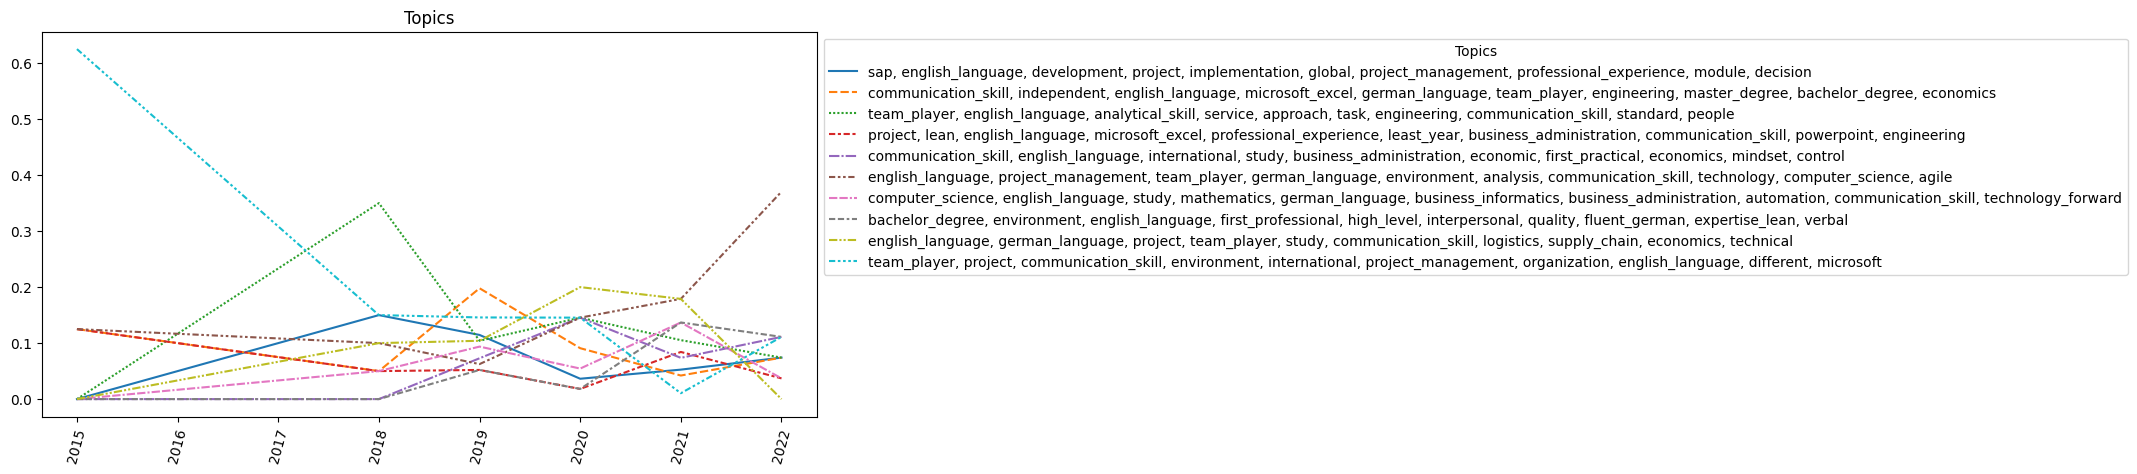

In [46]:
# Visualisation of the topics and their development over the years
fig, ax = plt.subplots(figsize=(10, 5))
main.plot(

    # Plot's title
    title = 'Topics',

    # Legend's title
    legend_title="Topics",

    # Set location to save
    # path_to_save="./plot_of_news.png",

    # Display graph (default)
    display=True,

    # Rotate labels in 75º
    rotation=75,

    # Plot lines (default)
    mode="line",

    # Set custom date format to YYYY
    date_format="%Y"
)

5.9 Visualisation of the topics and their development over the years (filter by topic)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Saving the topic probability
topic_probability = main.get_results()
topic_probability = topic_probability.set_index('date')

# Create a list of topic numbers for the checkboxes
topics = topic_probability.columns.tolist()

# Create a checkbox list for the topics
topics_checkboxes = widgets.SelectMultiple(
    options=topics,
    value=[topics[0]],  # Default value for the output selection
    description='Topics:',
    disabled=False,
    layout=widgets.Layout(height='150px')
)

# Create plot function
def plot_topics(topics):
    plt.clf()  # delete current plot

    fig, ax = plt.subplots(figsize=(10, 5))

    # Create line for each selected topic
    for topic in topics:
        plt.plot(topic_probability.index.year, topic_probability[topic], label=(main.get_topic_words(topic_id=topic, timeslice=len(year_dfs), n=15)))

    # Label axes
    plt.xlabel("Jahr")
    plt.ylabel("Probability")
    plt.xticks(range(min(topic_probability.index.year), max(topic_probability.index.year)+1), rotation=45)

    # Add title
    plt.title("Topic Probabilities im Zeitverlauf", fontsize=16)

    # Add legend
    plt.legend()
    plt.show()

# Link checkbox list with plot function
widgets.interactive(plot_topics, topics=topics_checkboxes)


interactive(children=(SelectMultiple(description='Topics:', index=(0,), layout=Layout(height='150px'), options…

5.10 Visualisation of topic words and their development over the years

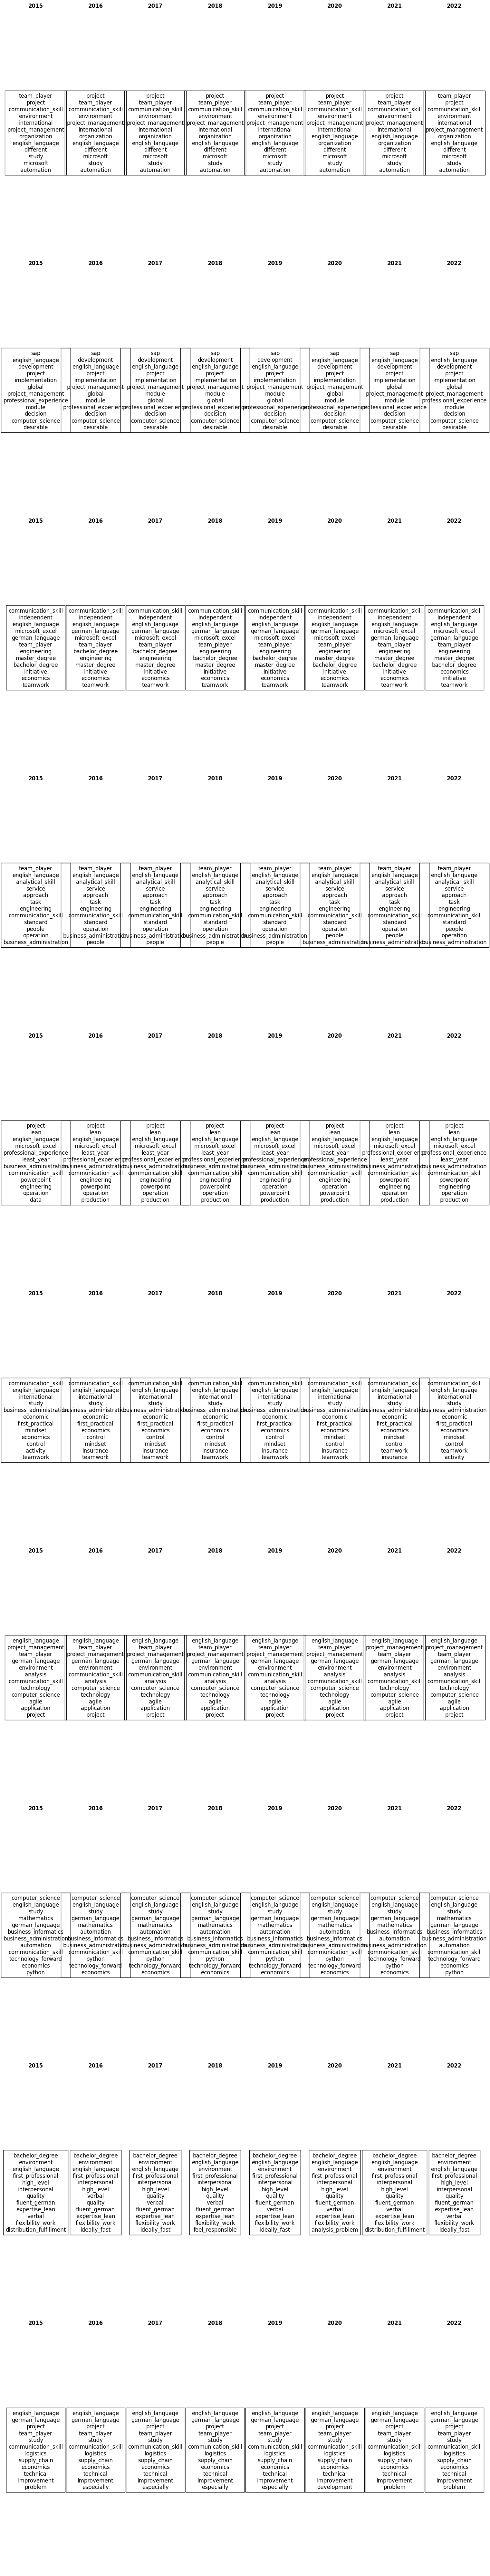

In [48]:
# disabled by default
'''
import matplotlib.pyplot as plt

def create_word_change_boxes(years, topics):
    num_years = len(years)
    num_topics = len(topics)

    fig, axs = plt.subplots(num_topics, num_years, figsize=(15, 80), sharex=True, sharey=True)

    for i, topic in enumerate(topics):
        for j, year in enumerate(years):
            words = main.get_topic_words(topic_id=i, timeslice=j, n=12)
            ax = axs[i, j]
            ax.text(0.5, 0.5, "\n".join(words), va="center", ha="center", fontsize=12, bbox=dict(facecolor='none', edgecolor='black', pad=5))
            ax.set_title(year, fontweight="bold")
            ax.axis("off")
            if i == num_topics - 1:
                ax.set_xlabel(f"Jahr {year}", fontweight="bold")

    plt.tight_layout()
    plt.show()


years = topic_probability.index.year
num_topics = 10  # Beispielwert, setzen Sie hier den tatsächlichen Wert Ihrer "num_topics" ein
topics_list = []

for i in range(1, n_topics + 1):
    topics_list.append(i)

topics = topics_list

create_word_change_boxes(years, topics)
'''

5.11 Save the developed lda-over-time model

In [49]:
path = '/content/drive/MyDrive/lda_over_time/filter_by_' + filter_type + '_tn_' + str(n_topics)
main.save(path)

5.12 Dirichlet Multinomial Regression (DMR)

Topic 0 Top Words: [('automation', 0.12976975739002228), ('database', 0.06491190195083618), ('initial', 0.05410226061940193), ('programming_language', 0.04869743809103966), ('java', 0.04329261556267738), ('challenge', 0.03788779675960541), ('term', 0.032482974231243134), ('infrastructure', 0.032482974231243134), ('robotic_process', 0.032482974231243134), ('course', 0.032482974231243134), ('average', 0.032482974231243134), ('college', 0.02707815356552601), ('contribute', 0.02707815356552601), ('approach', 0.02707815356552601), ('architecture', 0.02707815356552601)]
Topic 1 Top Words: [('team_player', 0.061426274478435516), ('english_language', 0.05191086605191231), ('engineering', 0.04931575432419777), ('technology', 0.02768983133137226), ('language', 0.02336464822292328), ('master_degree', 0.022499609738588333), ('affinity', 0.019904499873518944), ('french', 0.01817442663013935), ('german_language', 0.017309388145804405), ('computer_science', 0.017309388145804405), ('technical', 0.0164

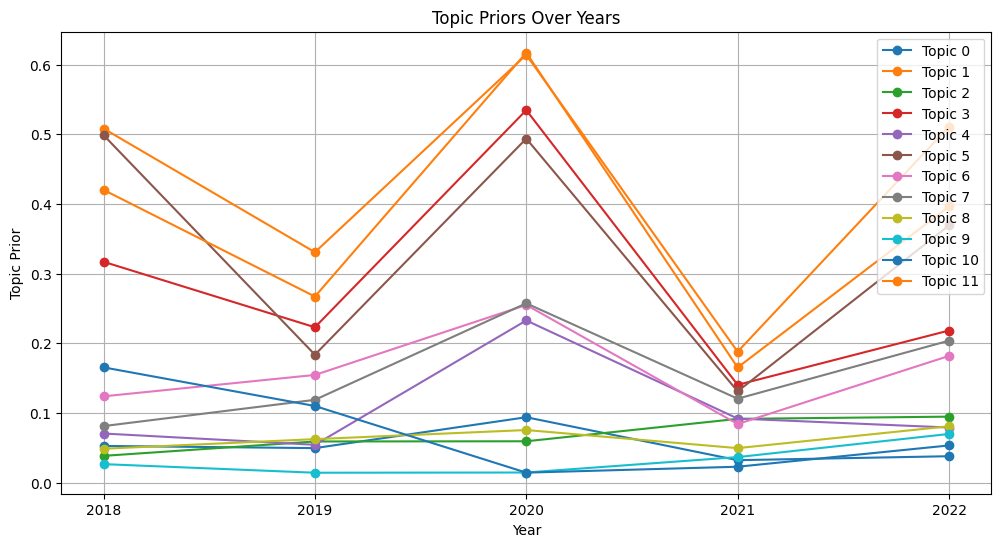

In [50]:
#!pip install tomotopy
import tomotopy as tp

# Create a DMR model
model = tp.DMRModel(k=12, min_cf=0, min_df=5)

docs_dmr = []
for doc in docs:
    words = doc.split()  # Splitting the current document into words
    docs_dmr.append(words)

# Adding documents with metadata (timestamps)
for words, year in zip(docs_dmr, timestamps_by_year):
    model.add_doc(words, metadata=str(year))

# Train the model
model.train(1000)

# 6. Evaluation

6.1 Evaluation of static LDA model for different number of topics

In [52]:
if calculate_coherence:
  from gensim.test.utils import common_corpus, common_dictionary
  from gensim.models.ldamodel import LdaModel
  from gensim.models.coherencemodel import CoherenceModel

  # Lists for storing coherence
  coherence_values_cv = []
  coherence_values_u_mass = []
  coherence_values_c_uci = []
  coherence = []

  for num_topics in range(1, 50, 1):

      # List of years
      years = docs_by_year.keys()

      # Save topic distribution for each year
      topic_distributions = {}

      # Combine all documents into a single corpus
      combined_documents = [document for year in years for document in docs_by_year[year]]

      # Convert documents to BoW format for the LDA model
      dictionary = corpora.Dictionary(combined_documents)

      # Remove words that appear in fewer than 10 documents or in more than 80% of the documents (deactivated by default)
      #dictionary.filter_extremes(no_below=10, no_above=0.8)

      # Define the corpus
      corpus = [dictionary.doc2bow(document) for document in combined_documents]

      # Train the LDA model on the entire corpus
      lda_model = LdaModel(
          corpus=corpus,
          id2word=dictionary,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          iterations=iterations,
          num_topics=num_topics,
          passes=passes,
          random_state=seed
      )

      # Calculation of coherence with the c_v coherence model
      coherence_model_cv = CoherenceModel(model=lda_model, texts=combined_documents, dictionary=dictionary, coherence='c_v')
      coherence_cv = coherence_model_cv.get_coherence()
      coherence_values_cv.append(coherence_cv)
      print(("Number of Topics: " + str(num_topics) + " -> Coherence (c_v): " + str(coherence_cv)))

      # Calculation of coherence with the u_mass coherence model
      coherence_model_u_mass = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
      coherence_u_mass = coherence_model_u_mass.get_coherence()
      coherence_values_u_mass.append(coherence_u_mass)
      #print(("Number of Topics: " + str(num_topics) + " -> Coherence (u_mass): " + str(coherence_model_u_mass.get_coherence())))


      # Calculation of coherence with the c_uci coherence model
      coherence_model_c_uci = CoherenceModel(model=lda_model, texts=combined_documents, dictionary=dictionary, coherence='c_npmi')
      coherence_c_uci = coherence_model_c_uci.get_coherence()
      coherence_values_c_uci.append(coherence_c_uci)
      print(("Number of Topics: " + str(num_topics) + " -> Coherence (c_npmi): " + str(coherence_c_uci)))


Number of Topics: 1 -> Coherence (c_v): 0.33101725934438764
Number of Topics: 1 -> Coherence (c_npmi): -0.0201790925586616
Number of Topics: 2 -> Coherence (c_v): 0.3424108361962189
Number of Topics: 2 -> Coherence (c_npmi): -0.04811848748099504


Number of Topics: 3 -> Coherence (c_v): 0.4381378796015077
Number of Topics: 3 -> Coherence (c_npmi): -0.03985968492120606
Number of Topics: 4 -> Coherence (c_v): 0.4743143836829474
Number of Topics: 4 -> Coherence (c_npmi): -0.03556390353134394
Number of Topics: 5 -> Coherence (c_v): 0.4898217942775053
Number of Topics: 5 -> Coherence (c_npmi): -0.055112757874061793
Number of Topics: 6 -> Coherence (c_v): 0.41247131632085315
Number of Topics: 6 -> Coherence (c_npmi): -0.07472091444190816
Number of Topics: 7 -> Coherence (c_v): 0.43508573281078505
Number of Topics: 7 -> Coherence (c_npmi): -0.08868333097590751
Number of Topics: 8 -> Coherence (c_v): 0.4343832932361742
Number of Topics: 8 -> Coherence (c_npmi): -0.08305299617768162
Number of Topics: 9 -> Coherence (c_v): 0.4766098074502716
Number of Topics: 9 -> Coherence (c_npmi): -0.06313995182574088
Number of Topics: 10 -> Coherence (c_v): 0.44639611455366734
Number of Topics: 10 -> Coherence (c_npmi): -0.07601190488721224
Number of 

6.2 Coherence score (c_v)

<Figure size 1000x500 with 0 Axes>

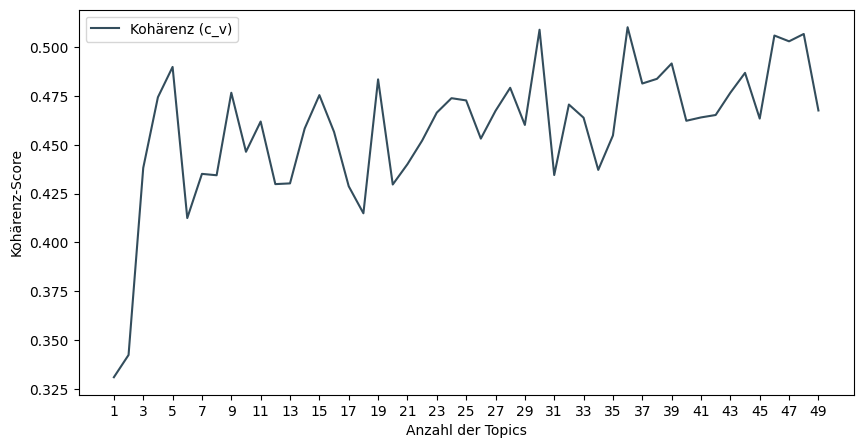

In [53]:
if calculate_coherence:
  import matplotlib.pyplot as plt

  # Set parameters
  limit = 50
  start = 1
  step = 1
  x = range(start, limit, step)

  # Set color
  color = '#334d5c'

  fig = plt.figure(figsize=(10,5))
  fig, ax = plt.subplots(figsize=(10,5))

  # Find the lowest coherence value
  max_coherence = max(coherence_values_cv)

  # Find the index of the lowest y-value
  index_min_y = np.argmax(coherence_values_cv)

  # Access the corresponding x-value with the found index
  x_min_y = x[index_min_y]

  # Plot the coherence line and line for the lowest value
  plt.plot(x, coherence_values_cv, color=color, label='Kohärenz (c_v)')
  #plt.axvline(x=x_min_y, color=color, linestyle='--')

  # Add text for best coherence value
  #best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{max_coherence:.2f})"
  #plt.text(x_min_y + 1, 0.34, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

  # Add ticks at full numbers on x-axis
  ax.set_xticks(np.arange(start, limit, 2))

  # Add labels and show plot
  plt.xlabel("Anzahl der Topics")
  plt.ylabel("Kohärenz-Score")
  #plt.title("Kohärenz-Score (c_v) für unterschiedliche Anzahl an Topics", fontsize=16)
  plt.legend()
  plt.show()

6.3 Coherence score (u_mass)

<Figure size 1000x500 with 0 Axes>

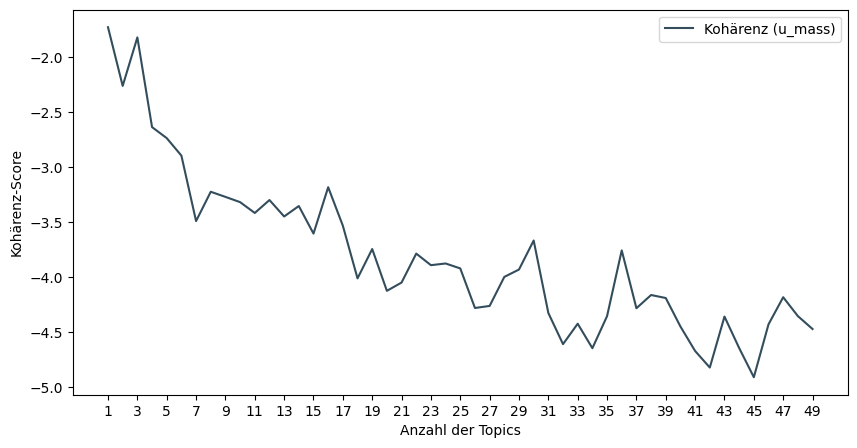

In [54]:
if calculate_coherence:
  import matplotlib.pyplot as plt

  # Set parameters
  limit = 50
  start = 1
  step = 1
  x = range(start, limit, step)

  # Set color
  color = '#334d5c'

  fig = plt.figure(figsize=(10,5))
  fig, ax = plt.subplots(figsize=(10,5))

  # Find the lowest coherence value
  min_coherence = min(coherence_values_u_mass)

  # Find the index of the lowest y-value
  index_min_y = np.argmin(coherence_values_u_mass)

  # Access the corresponding x-value with the found index
  x_min_y = x[index_min_y]

  # Plot the coherence line and line for the lowest value
  plt.plot(x, coherence_values_u_mass, color=color, label='Kohärenz (u_mass)')
  #plt.axvline(x=x_min_y, color=color, linestyle='--')

  # Add text for best coherence value
  #best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{min_coherence:.2f})"
  #plt.text(x_min_y + 2, -6, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

  # Add ticks at full numbers on x-axis
  ax.set_xticks(np.arange(start, limit, 2))

  # Add labels and show plot
  plt.xlabel("Anzahl der Topics")
  plt.ylabel("Kohärenz-Score")
  #plt.title("Kohärenz-Score (u_mass) für unterschiedliche Anzahl an Topics", fontsize=16)
  plt.legend()
  plt.show()

6.4 Coherence score (c_uci)

<Figure size 1000x500 with 0 Axes>

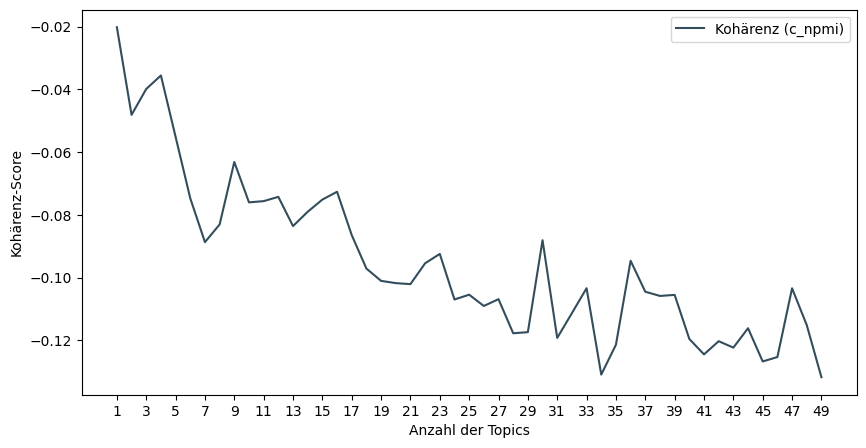

In [55]:
if calculate_coherence:
  import matplotlib.pyplot as plt

  # Set parameters
  limit = 50
  start = 1
  step = 1
  x = range(start, limit, step)

  # Set color
  color = '#334d5c'

  fig = plt.figure(figsize=(10,5))
  fig, ax = plt.subplots(figsize=(10,5))

  # Find the lowest coherence value
  min_coherence = min(coherence_values_c_uci)

  # Find the index of the lowest y-value
  index_min_y = np.argmin(coherence_values_c_uci)

  # Access the corresponding x-value with the found index
  x_min_y = x[index_min_y]

  # Plot the coherence line and line for the lowest value
  plt.plot(x, coherence_values_c_uci, color=color, label='Kohärenz (c_npmi)')
  #plt.axvline(x=x_min_y, color=color, linestyle='--')

  # Add text for best coherence value
  #best_coherence_text = "Best coherence score \nfor " + f"{x_min_y:.0f} topics (" + f"{min_coherence:.2f})"
  #plt.text(x_min_y + 2, -6, best_coherence_text, fontsize=12, color=color, rotation='horizontal')

  # Add ticks at full numbers on x-axis
  ax.set_xticks(np.arange(start, limit, 2))

  # Add labels and show plot
  plt.xlabel("Anzahl der Topics")
  plt.ylabel("Kohärenz-Score")
  #plt.title("Kohärenz-Score (u_mass) für unterschiedliche Anzahl an Topics", fontsize=16)
  plt.legend()
  plt.show()